# Personalized logical models to investigate cancer response to BRAF treatments in melanomas and colorectal cancers

### Installation
In order run the following notebook you will need this libraries:
* pip install maboss
* pip install maboss_test

In [1]:
import maboss
import maboss_test

## GINsim Model:

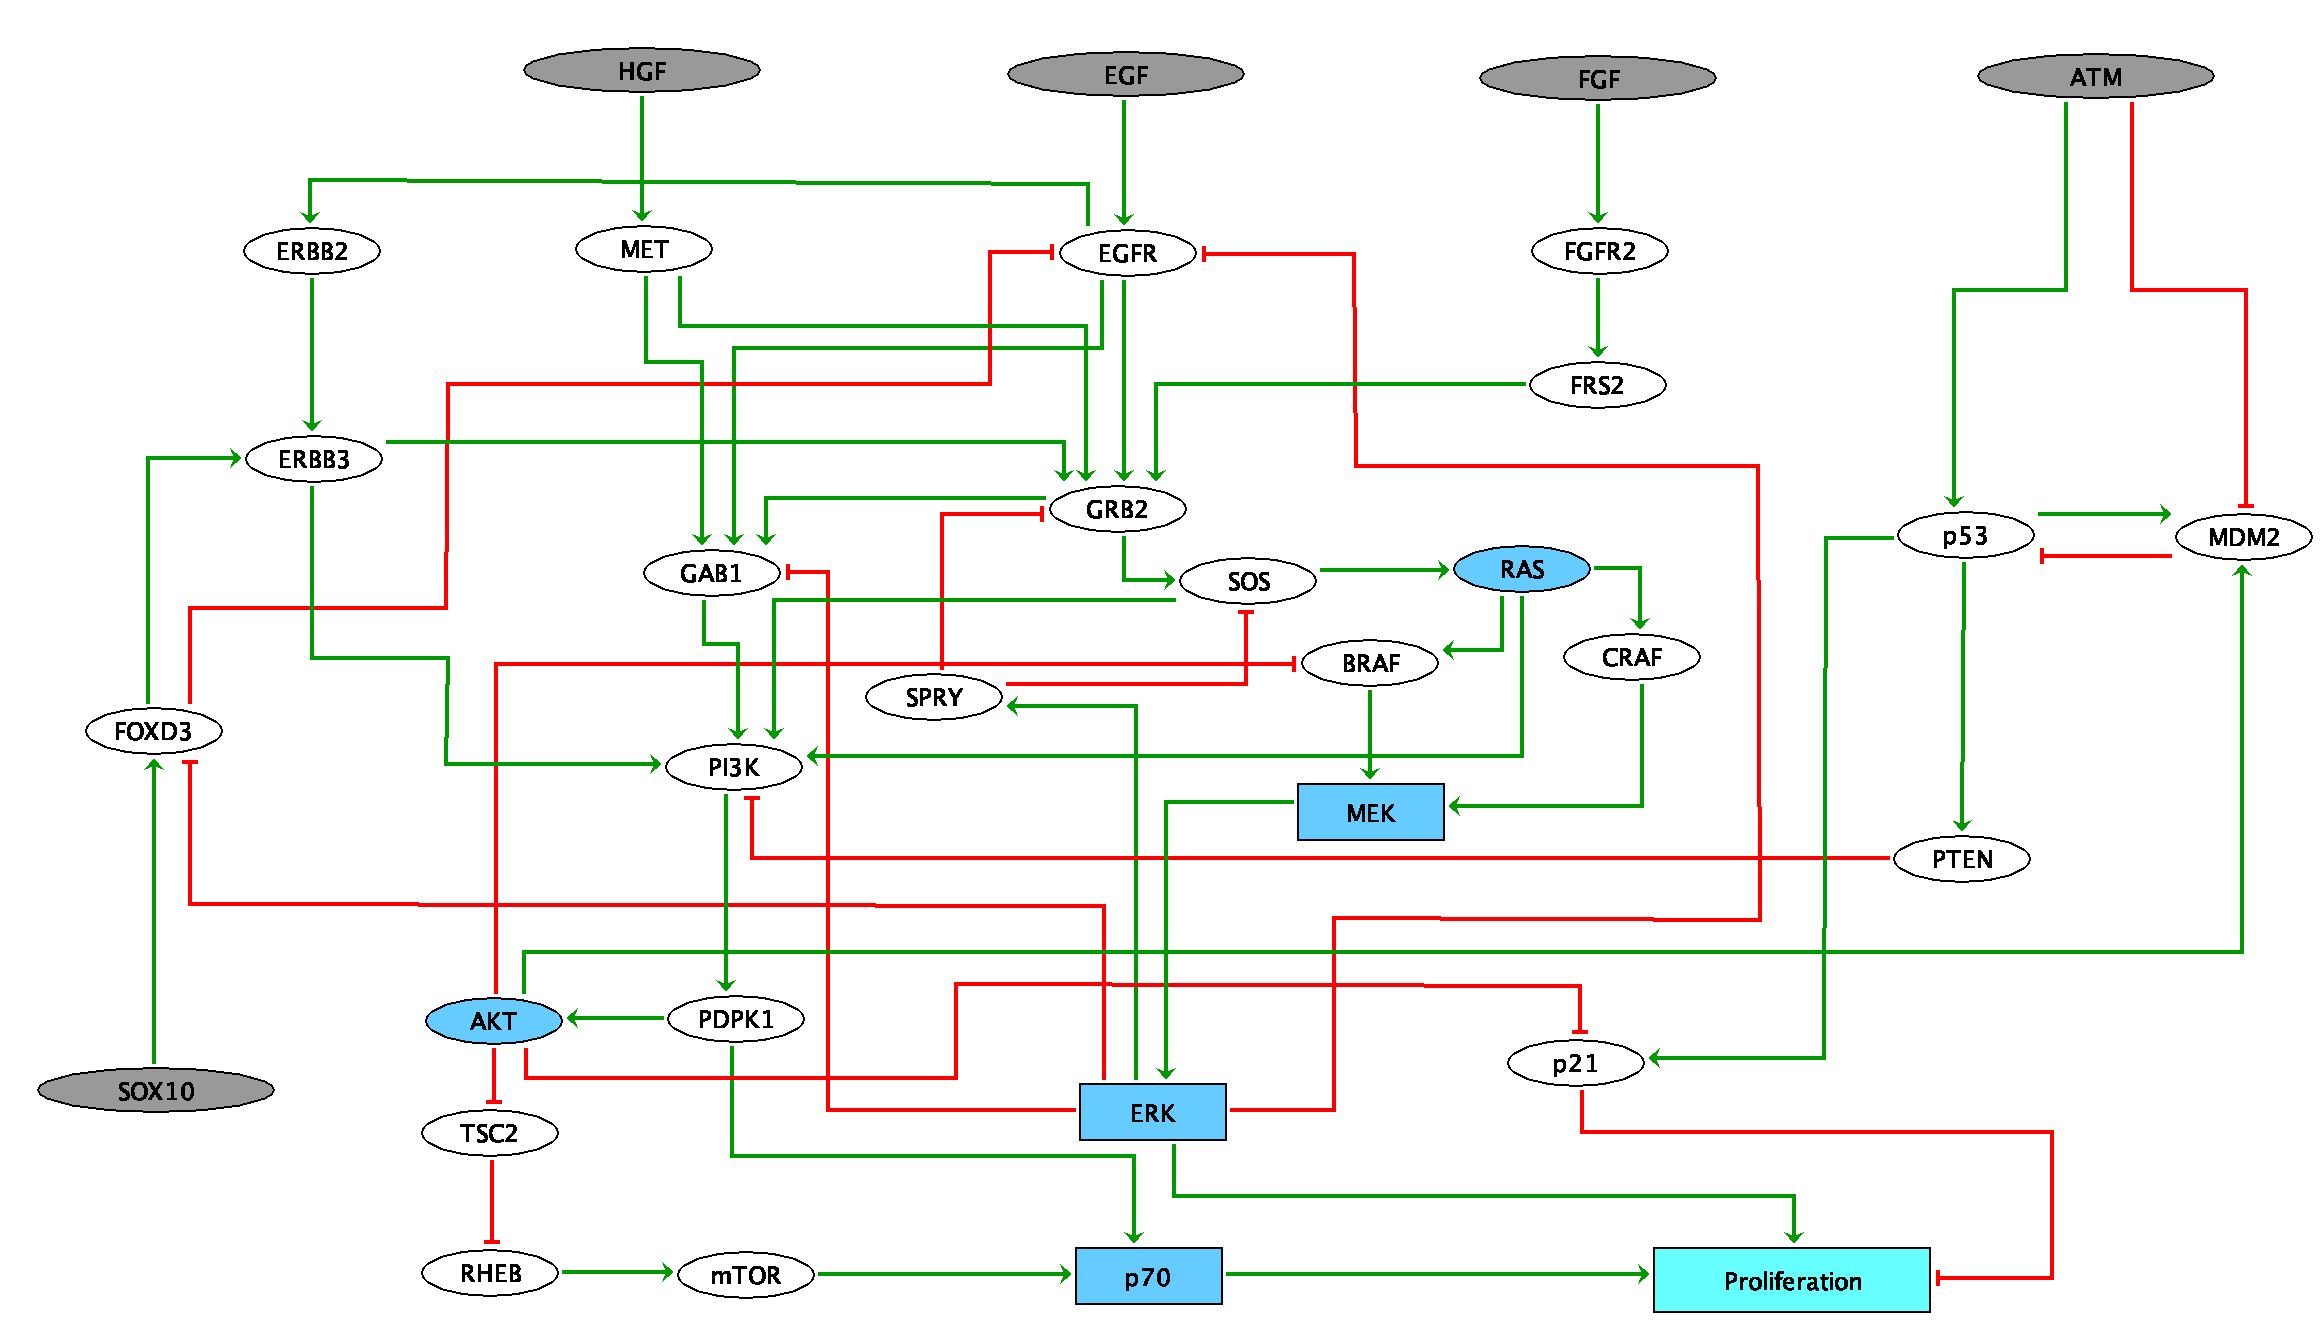

In [2]:
from IPython.display import Image
Image("Model.png")

## Simulation of the wild tipe model

import the model the MaBoSS version of the model:

In [3]:
BRAF_model = maboss.load("BRAF_Model.bnd", "BRAF_Model.cfg")

### We simulate the model without any mutation and plot the probability to have the level of proliferation active:

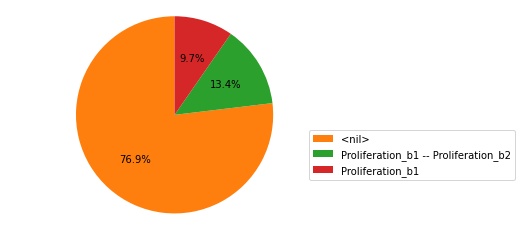

In [4]:
WT_model = BRAF_model.copy()
WT_model.network.set_output(('Proliferation_b1','Proliferation_b2'))

results_WT_model = WT_model.run()
# Plot pie chart
results_WT_model.plot_piechart()

### Now we show again the same simulation but with BRAF mutated

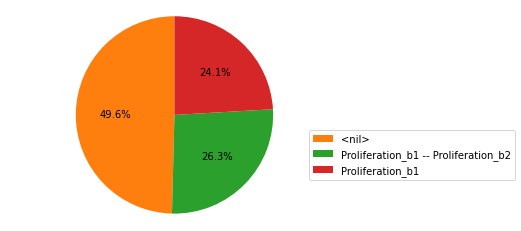

In [5]:
BRAFV600E_model = BRAF_model.copy()
BRAFV600E_model.mutate('BRAF', 'ON')
BRAFV600E_model.network.set_output(('Proliferation_b1','Proliferation_b2' ))

results_BRAFV600E_model = BRAFV600E_model.run()
# Plot pie chart
results_BRAFV600E_model.plot_piechart()

## Automatized model-checking within unit-testing framework
 

In this notebook we test the consistence of our model through the unit-testing framework we developed.


![title](assertion_table.png)

## Prepare the tool:

(for a brief tutorial of the tool go at: https://maboss-test.readthedocs.io/en/latest/?badge=latest)


### Create the objects to perform the tests

We build two different objects, one corresponding to the network which presents the mutated form of BRAF (BRAF_ON) and the other for the treated network (BRAF_OFF).

In [6]:
BRAFV600E = maboss.load("BRAF_Model.bnd", "BRAF_Model.cfg")

BRAFV600E.mutate('BRAF', 'ON')
test_BRAF_ON = maboss_test.MaBoSSTestCase(BRAFV600E)   #tester for the BRAF mutated network

BRAFV600E.mutate('BRAF', 'OFF')
test_BRAF_OFF = maboss_test.MaBoSSTestCase(BRAFV600E)  #tester for the treated network

### Definition of some useful variables:

As we mentioned in the article, CRC and melanoma present different level of expression of SOX10. 
We define the intial conditions:

In [7]:
IC_CRC = {'SOX10':[1,0]}    #initial conditions for CRC: SOX10 not expressed 
IC_Mela = {'SOX10':[0,1]}   #initial conditions for melanoma: SOX10 expressed

Variables to simulate different kind of treatment:

In [8]:
BRAF_inhibition = {'BRAF':'OFF'}
MEK_inhibition =  {'MEK_b1':'OFF', 'MEK_b2':'OFF'}
BRAF_EGFR_inhibition = {'BRAF' :'OFF', 'EGFR':'OFF'}
BRAF_MEK_PI3K_inhibition = {'BRAF':'OFF', 'MEK_b1':'OFF', 'MEK_b2':'OFF', 'PI3K':'OFF'}

## Assertions list:

Notice: in the following tests the initial conditions are random for every node (each node starts with a 50% probability to be active), except when they are specifically changed (second argument of the function).

### Assertion 1

* source: doi:10.1038/nature10868
* assertion: BRAF inhibition causes a feedback activation of EGFR in colorectal cancer andnot in melanoma.


In [9]:
test_BRAF_ON.assertStateProbabilityEvolution(BRAF_inhibition, IC_CRC, {'EGFR':1}, 'increase', digits=1)

True!  
The new probability of reaching the state is: 0.278416 
The old one is: 0


In [10]:
test_BRAF_ON.assertStateProbabilityEvolution(BRAF_inhibition, IC_Mela, {'EGFR':1}, 'stable', digits=1)

True!  
The new probability of reaching the state is: 0.035271 
The old one is: 0


The probability to have the riactivation of EGFR is higher in CRC than in melanoma.

### Assertion 2

* source: doi: 10.1158/0008-5472.CAN-10-0902, doi 10.1007/s00018-016-2297-8
* assertion: MEK inhibition stops ERK signal but activates the PI3K/Akt pathway and increases the activity of  ERBB3.

MEK inhibition stops ERK signal

In [11]:
test_BRAF_ON.assertStateProbabilityEvolution(MEK_inhibition, {}, {'ERK_b1':1}, 'decrease')

Warning, you did not change any initial condition!
True!  
The new probability of reaching the state is: 0 
The old one is: 1.0


In [12]:
test_BRAF_ON.assertStateProbabilityEvolution(MEK_inhibition, {}, {'ERK_b2':1}, 'decrease')

Warning, you did not change any initial condition!
True!  
The new probability of reaching the state is: 0 
The old one is: 1.0


but activates the PI3K/Akt pathway

In [13]:
test_BRAF_ON.assertStateProbabilityEvolution(MEK_inhibition, {}, {'PI3K':1,'AKT':1}, 'increase')

Warning, you did not change any initial condition!
True!  
The new probability of reaching the state is: 0.462 
The old one is: 0.2456


and increases the activity of both EGFR and ERBB3.

In [14]:
test_BRAF_ON.assertStateProbabilityEvolution(MEK_inhibition, {}, {'EGFR':1}, 'increase')

Warning, you did not change any initial condition!
True!  
The new probability of reaching the state is: 0.259 
The old one is: 0


### Assertion 3
* source: doi:10.1038/nature11183.
* assertion: HGF signal leads to the reactivation of the MAPK and PI3K/AKT pathways, and resistance to BRAF inhibition.


In [15]:
test_BRAF_OFF.assertStateProbabilityEvolution({'HGF':'ON'}, {}, {'PI3K':1,'AKT':1}, 'increase' )

Warning, you did not change any initial condition!
True!  
The new probability of reaching the state is: 0.4946 
The old one is: 0.337801


In [16]:
test_BRAF_OFF.assertStateProbabilityEvolution({'HGF':'ON'}, {}, {'ERK_b1':1}, 'increase' )

Warning, you did not change any initial condition!
True!  
The new probability of reaching the state is: 0.45903 
The old one is: 0.431094


### Assertion 4

* source: DOI: 10.1038/s41467-017-02354-x

* assertion: BRAF inhibition in melanoma activates the SOX10/FOXD3/ERBB3 axis, which mediates resistance through the activation of the PI3K/AKT pathway.

In [17]:
axis = {'SOX10':1,'FOXD3': 1,'ERBB3':1}

In [18]:
test_BRAF_ON.assertStateProbabilityEvolution(BRAF_inhibition, IC_Mela, axis, 'increase')

True!  
The new probability of reaching the state is: 0.475832 
The old one is: 0


In [19]:
test_BRAF_ON.assertStateProbabilityEvolution(BRAF_inhibition, IC_Mela, {'ERBB3':1,'PI3K':1,'AKT':1}, 'increase')

True!  
The new probability of reaching the state is: 0.241214 
The old one is: 0


* assertion: depletion of SOX10 would sensitize melanoma cells to the BRAF inhibitors.

In [20]:
test_BRAF_OFF.assertStateProbabilityEvolution({'SOX10':'OFF'}, IC_Mela, {'Proliferation_b1':1}, 'decrease')

True!  
The new probability of reaching the state is: 0.209514 
The old one is: 0.244587


In [21]:
test_BRAF_OFF.assertStateProbabilityEvolution({'SOX10':'OFF'}, IC_Mela, {'Proliferation_b2':1}, 'decrease')

True!  
The new probability of reaching the state is: 0.118466 
The old one is: 0.145325


### Assertion 5

* source: doi: 10.21037/atm.2016.06.07
* source: Overexpression/mutation of CRAF results in constitutive activation of ERK and MEK also in the presence of a BRAF inhibitor.

In order to thest this assertion we build a simulation with both BRAF and CRAF constitutively active:

In [22]:
BRAFV600E.mutate('BRAF', 'ON')
BRAFV600E.mutate('CRAF', 'ON')
test_BRAF_CRAF_ON = maboss_test.MaBoSSTestCase(BRAFV600E)

In [23]:
test_BRAF_CRAF_ON.assertStateProbabilityEvolution(BRAF_inhibition, {}, {'MEK_b1':1,'ERK_b1':1}, 'stable')

Warning, you did not change any initial condition!
True!  
The new probability of reaching the state is: 1.0 
The old one is: 1.0


### Assertion 6

* source: doi: 10.21037/atm.2016.06.07
* assertion: Early resistance to BRAF inhibition may be observed in case of PTEN loss, or mutations in PI3K or AKT.

PTEN loss leads to an increase of proliferation in BRAF treated patients

In [24]:
test_BRAF_OFF.assertStateProbabilityEvolution({'PTEN':'OFF'}, {}, {'Proliferation_b1':1}, 'increase')

Warning, you did not change any initial condition!
True!  
The new probability of reaching the state is: 0.425284 
The old one is: 0.22255


In [25]:
test_BRAF_OFF.assertStateProbabilityEvolution({'PTEN':'OFF'}, {}, {'Proliferation_b2':1}, 'increase')

Warning, you did not change any initial condition!
True!  
The new probability of reaching the state is: 0.263994 
The old one is: 0.124011


PI3K or AKT activation lead to an increase of proliferation in BRAF treated patients

In [26]:
test_BRAF_OFF.assertStateProbabilityEvolution({'PI3K':'ON'}, {}, {'Proliferation_b1':1}, 'increase')

Warning, you did not change any initial condition!
True!  
The new probability of reaching the state is: 0.499279 
The old one is: 0.22436


In [27]:
test_BRAF_OFF.assertStateProbabilityEvolution({'PI3K':'ON'}, {}, {'Proliferation_b2':1}, 'increase')

Warning, you did not change any initial condition!
True!  
The new probability of reaching the state is: 0.361824 
The old one is: 0.129211


In [28]:
test_BRAF_OFF.assertStateProbabilityEvolution({'AKT':'ON'}, {}, {'Proliferation_b1':1}, 'increase')

Warning, you did not change any initial condition!
True!  
The new probability of reaching the state is: 0.446788 
The old one is: 0.228203


In [29]:
test_BRAF_OFF.assertStateProbabilityEvolution({'AKT':'ON'}, {}, {'Proliferation_b2':1}, 'increase')

Warning, you did not change any initial condition!
True!  
The new probability of reaching the state is: 0.148955 
The old one is: 0.135235


### Assertion 7

* source: doi: 10.21037/atm.2016.06.07
* Experiments in melanoma cell lines support combined treatment with BRAF/MEK + PI3K/AKT inhibitors to overcome resistance.




In [30]:
test_BRAF_ON.assertStateProbabilityEvolution(BRAF_MEK_PI3K_inhibition, {}, {'Proliferation_b1':1}, 'decrease')

Warning, you did not change any initial condition!
True!  
The new probability of reaching the state is: 0 
The old one is: 0.5012


In [31]:
test_BRAF_ON.assertStateProbabilityEvolution(BRAF_MEK_PI3K_inhibition, {}, {'Proliferation_b2':1}, 'decrease')

Warning, you did not change any initial condition!
True!  
The new probability of reaching the state is: 0 
The old one is: 0.2508


### Assertion 8

* source: doi:10.1158/2159-8290.CD-11-0341.
* BRAF inhibition (Vemurafenib) also leads to induction of PI3K/AKT pathway and inhibition of EGFR did not block this induction.


In [32]:
test_BRAF_ON.assertStateProbabilityEvolution(BRAF_inhibition, {}, {'PI3K':1,'AKT':1}, 'increase')

Warning, you did not change any initial condition!
True!  
The new probability of reaching the state is: 0.355729 
The old one is: 0.2486


In [33]:
test_BRAF_ON.assertStateProbabilityEvolution(BRAF_EGFR_inhibition, {}, {'PI3K':1,'AKT':1}, 'increase')

Warning, you did not change any initial condition!
True!  
The new probability of reaching the state is: 0.337245 
The old one is: 0.2546


''Despite the profound effect of this combination on cell viability'':
the inhibition of both EGFR and BRAF when the EGF signal is strong is better than just BRAF inhibition

In [34]:
test_BRAF_ON.assertStateProbabilityEvolution(BRAF_EGFR_inhibition, {'EGF':[0,1]}, {'Proliferation_b1':1}, 'decrease')

True!  
The new probability of reaching the state is: 0.203593 
The old one is: 0.5082


In [35]:
test_BRAF_ON.assertStateProbabilityEvolution(BRAF_inhibition, {'EGF':[0,1]}, {'Proliferation_b1':1}, 'decrease')

True!  
The new probability of reaching the state is: 0.228733 
The old one is: 0.4988


### Assertion 9:

* source: doi:10.1158/2159-8290.CD-11-0341
* assertion: Induction of PI3K-AKT pathway signaling has been associated with decreased sensitivity to MAPK inhibition.


In [36]:
test_BRAF_OFF.assertStateProbabilityEvolution({'PI3K':'ON'}, {}, {'Proliferation_b1':1}, 'increase')

Warning, you did not change any initial condition!
True!  
The new probability of reaching the state is: 0.504934 
The old one is: 0.223471


In [37]:
test_BRAF_OFF.assertStateProbabilityEvolution({'PI3K':'ON'}, {}, {'Proliferation_b2':1}, 'increase')

Warning, you did not change any initial condition!
True!  
The new probability of reaching the state is: 0.361837 
The old one is: 0.143544
